# Einfluss Membranpotenzial in Abhängigkeit von Ionenkonzentrazionen

## Importieren der benötigten Bibliotheken

In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

## Implementierung Nernst-Gleichung für Gleichgewichtspotenzial

Erst Testung mit normalen Werten.

In [2]:

def nernst_potential(X_out, X_in, T = 273.15 + 37, z = 1):
    # Beispiel: Berechnung des Gleichgewichtspotentials für Kalium bei 37 Grad Celsius
    # T = 273.15 + 37    # Absolute Temperatur in K
    # z = 1    # Ladung von Kalium / Natrium
    # K_out = 5    # Konzentration von Kalium außerhalb der Zelle in mM
    #K_in = 140    # Konzentration von Kalium innerhalb der Zelle in mM    

    R = 8.314    # Universelle Gaskonstante in J/(mol*K)
    F = 96485    # Faraday-Konstante in C/mol

    E = (R * T) / (z * F) * np.log(X_out / X_in)

    return E*1000

K_out = 5    # Konzentration von Kalium außerhalb der Zelle in mM
K_in = 140    # Konzentration von Kalium innerhalb der Zelle in mM

E_K = nernst_potential(K_out, K_in)

print(f"Das Gleichgewichtspotential für Kalium beträgt {E_K} mV.")

Na_out = 145    # Konzentration von Natrium außerhalb der Zelle in mM
Na_in = 15    # Konzentration von Natrium innerhalb der Zelle in mM

E_Na = nernst_potential(Na_out, Na_in)

print(f"Das Gleichgewichtspotential für Natrium beträgt {E_Na} mV.")

Das Gleichgewichtspotential für Kalium beträgt -89.05404533864952 mV.
Das Gleichgewichtspotential für Kalium beträgt 60.63116664378764 mV.


Wie ändert sich Gleichgewichtspotenzial in Abhängigkeit von extrazellulärer Ionenkonzentration (intrazelluläre Konzentration konstant).

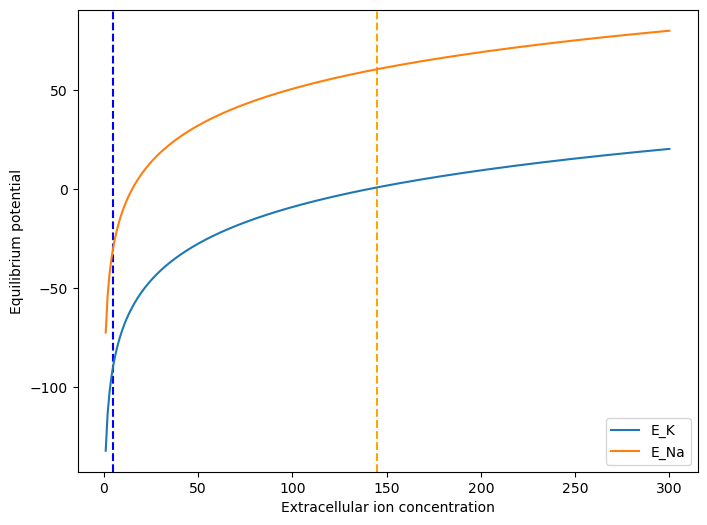

In [3]:

Na_out = np.arange(1, 301, 1)
K_out = np.arange(1, 301, 1)

E_K_all = np.zeros(len(K_out))
E_Na_all = np.zeros(len(Na_out))

for i in range(len(K_out)):
    E_K_all[i] = nernst_potential(K_out[i], K_in)
    E_Na_all[i] = nernst_potential(Na_out[i], Na_in)

plt.figure(figsize=(8, 6))
plt.axvline(x=5, color='blue', linestyle='--')
plt.axvline(x=145, color='orange', linestyle='--')
plt.plot(K_out, E_K_all, label='E_K')
plt.plot(Na_out, E_Na_all, label='E_Na')
plt.xlabel('Extracellular ion concentration')
plt.ylabel('Equilibrium potential')
plt.legend()
plt.show()

## Implementierung Goldmann-Gleichung zur Berechnung von Ruhepotenzial

Wie verändert sich Ruhepotenzial durch Veränderung der extrazellulären Konzentration von Kalium bzw Natrium?

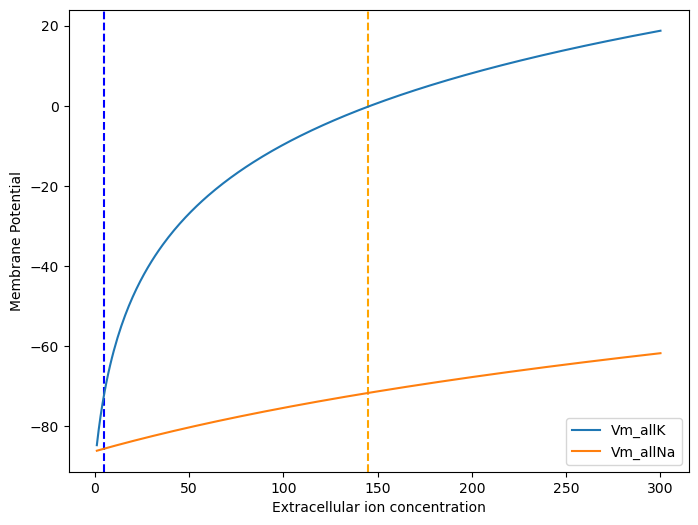

In [4]:
def goldman_potential(K_out, K_in, Na_out, Na_in, Cl_out, Cl_in, T = 273.15 + 37, 
                      P_K = 1, P_Na = 0.03, P_Cl = .1):
    R = 8.314    # Universelle Gaskonstante in J/(mol*K)
    F = 96485    # Faraday-Konstante in C/mol

    Vm = (R * T) / F * np.log((P_K*K_out + P_Na*Na_out + P_Cl*Cl_in) / (P_K*K_in + P_Na*Na_in + P_Cl*Cl_out))

    return Vm * 1000

# Beispiel: Berechnung des Ruhepotentials
Cl_out = 110    # Konzentration von Chlorid außerhalb der Zelle in mM
Cl_in = 10    # Konzentration von Chlorid innerhalb der Zelle in mM


Vm_allK = np.zeros(len(K_out))
Vm_allNa = np.zeros(len(Na_out))

for i in range(len(K_out)):
    Vm_allK[i] = goldman_potential(K_out[i], K_in, 145, Na_in, Cl_out, Cl_in) # Na konstant
    Vm_allNa[i] = goldman_potential(5, K_in, Na_out[i], Na_in, Cl_out, Cl_in) #K konstant

plt.figure(figsize=(8, 6))
plt.axvline(x=5, color='blue', linestyle='--')
plt.axvline(x=145, color='orange', linestyle='--')
plt.plot(K_out, Vm_allK, label='Vm_allK')
plt.plot(Na_out, Vm_allNa, label='Vm_allNa')
plt.xlabel('Extracellular ion concentration')
plt.ylabel('Membrane Potential')
plt.legend()
plt.show()

## Effekte auf Aktionspotenziale

Implementierung eines einzelnen “spiking“ Neurons und Testung der Gesamtzahl der Aktionspotenziale in 1s.

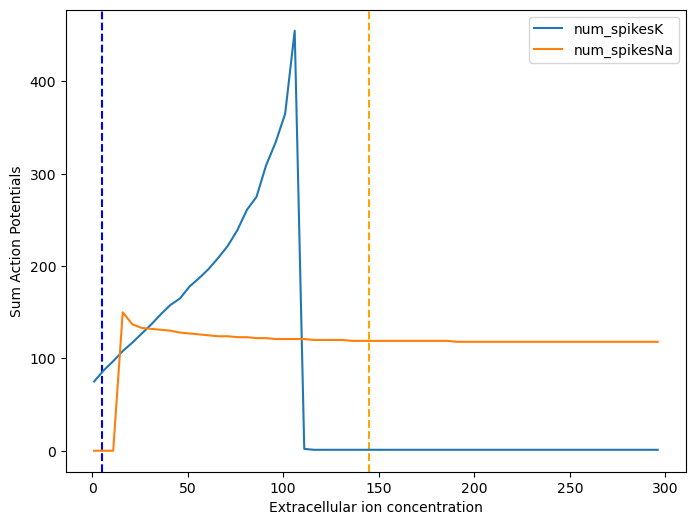

In [8]:
# Parameter des Hodgkin-Huxley-Modells
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

# Hodgkin-Huxley-Modell
eqs_HH = """
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
"""

Na_out = np.arange(1, 301, 5)
K_out = np.arange(1, 301, 5)

num_spikesK = np.zeros(len(K_out))
num_spikesNa = np.zeros(len(Na_out))

for i in range(len(K_out)):

    #Change Potassium
    EK = int(np.round(E_K_all[i]))*mV # MAKE THIS VARIABLE TO SHOW WHAT HAPPENS TO SPIKES
    ENa = int(np.round(nernst_potential(145, 15)))*mV
    
    net = Network()
    group = NeuronGroup(1, eqs_HH,
                        threshold='v > -40*mV',
                        refractory='v > -40*mV',
                        method='exponential_euler')

    group.v = El
    statemon = StateMonitor(group, 'v', record=True)
    net.add(group)
    net.add(statemon)
    spikemon = SpikeMonitor(group, variables='v')
    net.add(spikemon)
    net.run(10*ms, report=None)
    group.I = 1*nA
    net.run(1000*ms, report=None)
    spikemon.active = False
    num_spikesK[i] = len(spikemon.v)
    
    #Change Sodium
    ENa = int(np.round(E_Na_all[i]))*mV # MAKE THIS VARIABLE TO SHOW WHAT HAPPENS TO SPIKES
    EK = int(np.round(nernst_potential(5, 140)))*mV
    
    net = Network()
    group = NeuronGroup(1, eqs_HH,
                        threshold='v > -40*mV',
                        refractory='v > -40*mV',
                        method='exponential_euler')

    group.v = El
    statemon = StateMonitor(group, 'v', record=True)
    net.add(group)
    net.add(statemon)
    spikemon = SpikeMonitor(group, variables='v')
    net.add(spikemon)
    net.run(10*ms, report=None)
    group.I = 1*nA
    net.run(1000*ms, report=None)
    spikemon.active = False
    num_spikesNa[i] = len(spikemon.v)
    
plt.figure(figsize=(8, 6))
plt.axvline(x=5, color='blue', linestyle='--')
plt.axvline(x=145, color='orange', linestyle='--')
plt.plot(K_out, num_spikesK, label='num_spikesK')
plt.plot(Na_out, num_spikesNa, label='num_spikesNa')
plt.xlabel('Extracellular ion concentration')
plt.ylabel('Sum Action Potentials')
plt.legend()
plt.show()